# Vanilla models test

- Artificial Neural Networks
- Decision Tree Classifier
- Random Forest
- Gradient Boosting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2433988178986165830
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17198104612405736873
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [4]:
train_dir = 'data/real_vs_fake/real-vs-fake/train'
valid_dir = 'data/real_vs_fake/real-vs-fake/valid'
test_dir =  'data/real_vs_fake/real-vs-fake/test'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
batch_size = 32
image_height = 256
image_width = 256

# Create the generators for training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',     # Set the class mode to 'binary' since have two classes
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


fake images have label 0 and real images have label 1

In [7]:
classes = list(train_generator.class_indices.keys())
classes

['fake', 'real']

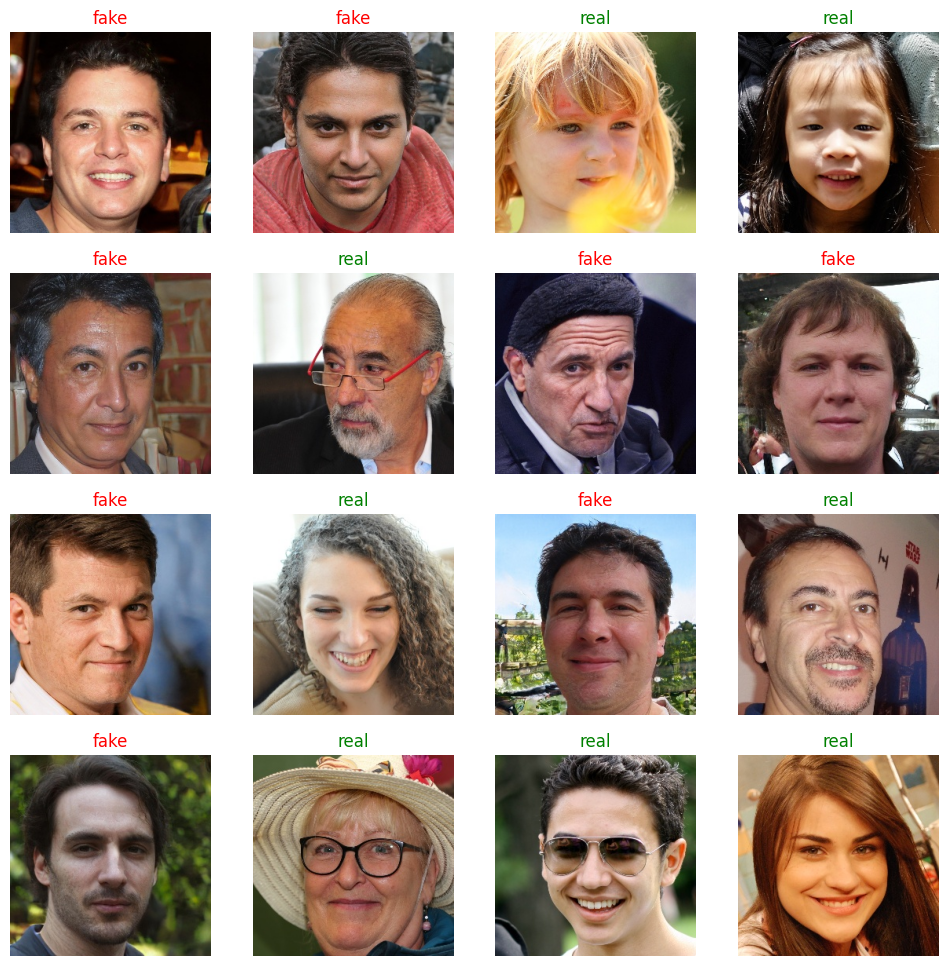

In [8]:
# Checking some images
images, labels = train_generator.next()

# Display the images along with their labels
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')

    if int(labels[i]) == 0:
        title_color = 'red'
    else:
        title_color = 'green'

    ax.set_title(classes[int(labels[i])], color=title_color)

plt.show()

## Convolutional neural network

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, DepthwiseConv2D

In [10]:
# Model
cnn = Sequential()

# Convolutional layers
cnn.add(Conv2D(16, (5, 5), activation='relu',padding='same',strides=(1,1),input_shape=(image_height, image_width, 3)))
cnn.add(Conv2D(32, (3, 3), activation='relu',padding='same',strides=(2,2)))
cnn.add(Conv2D(32, (3, 3), activation='relu',padding='same',strides=(1,1)))
cnn.add(Conv2D(64, (3, 3), activation='relu',padding='same',strides=(2,2)))
cnn.add(Conv2D(64, (3, 3), activation='relu',padding='same',strides=(1,1)))
cnn.add(Conv2D(128, (3, 3), activation='relu',padding='same',strides=(2,2)))
cnn.add(Conv2D(128, (3, 3), activation='relu',padding='same',strides=(1,1)))

# Depthwise-pointwise convolution layeras to reduce computation
cnn.add(DepthwiseConv2D((3,3), activation='relu',padding='same',strides=(2,2)))
cnn.add(Conv2D(128, (1,1), activation='relu'))
cnn.add(DepthwiseConv2D((3,3), activation='relu',padding='same',strides=(1,1)))
cnn.add(Conv2D(128, (1,1), activation='relu'))
cnn.add(DepthwiseConv2D((3,3), activation='relu',padding='same',strides=(2,2)))
cnn.add(Conv2D(128, (1,1), activation='relu'))
cnn.add(DepthwiseConv2D((3,3), activation='relu',padding='same',strides=(1,1)))
cnn.add(Conv2D(128, (1,1), activation='relu'))
cnn.add(DepthwiseConv2D((3,3), activation='relu',padding='same',strides=(2,2)))
cnn.add(Conv2D(128, (1,1), activation='relu'))
cnn.add(DepthwiseConv2D((3,3), activation='relu',padding='same',strides=(1,1)))
cnn.add(Conv2D(128, (1,1), activation='relu'))
cnn.add(Conv2D(128, (4, 4), activation='relu',padding='valid',strides=(1,1)))

# # Flatten layer to feed into dense Dense
cnn.add(Flatten())

# Dense
cnn.add(Dense(1, activation='sigmoid'))  # Adjust the number of classes

In [11]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
cnn.compile(optimizer='adam'
            ,loss='binary_crossentropy'
            ,metrics=['acc',f1_m,precision_m, recall_m])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       1

In [13]:
cnn_history = cnn.fit(train_generator, epochs=10,validation_data=valid_generator)

Epoch 1/10
3125/3125 [==============================] - 1269s 401ms/step - loss: 0.6932 - acc: 0.4984 - f1_m: 0.2855 - precision_m: 0.2153 - recall_m: 0.4323 - val_loss: 0.6932 - val_acc: 0.5000 - val_f1_m: 0.6622 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 2/10
3125/3125 [==============================] - 596s 191ms/step - loss: 0.6932 - acc: 0.4985 - f1_m: 0.3908 - precision_m: 0.2949 - recall_m: 0.5914 - val_loss: 0.6932 - val_acc: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/10
3125/3125 [==============================] - 728s 233ms/step - loss: 0.6932 - acc: 0.4990 - f1_m: 0.3269 - precision_m: 0.2467 - recall_m: 0.4944 - val_loss: 0.6931 - val_acc: 0.5000 - val_f1_m: 0.6621 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 4/10
3125/3125 [==============================] - 446s 143ms/step - loss: 0.6932 - acc: 0.4995 - f1_m: 0.3008 - precision_m: 0.2272 - recall_m: 0.4550 - val_loss: 0.6932 - val_acc: 0.5000 - val_f

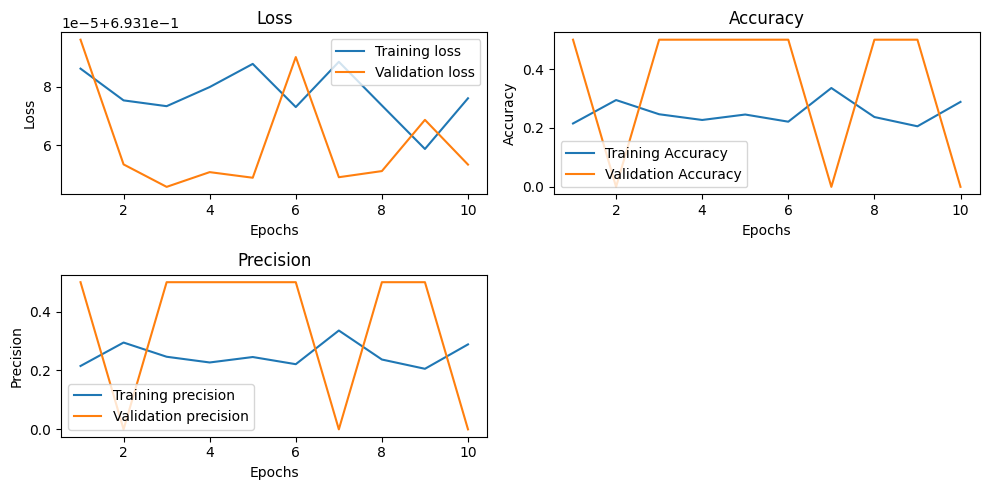

In [16]:
# Visualizing results
training_loss = cnn_history.history['loss']
validation_loss = cnn_history.history['val_loss']
training_accuracy = cnn_history.history['acc']
validation_accuracy = cnn_history.history['val_acc']
training_precision = cnn_history.history['precision_m']
validation_precision = cnn_history.history['val_precision_m']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, training_precision, label='Training Accuracy')
plt.plot(epochs, validation_precision, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, training_precision, label='Training precision')
plt.plot(epochs, validation_precision, label='Validation precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Testing set
cnn.evaluate(test_generator)

625/625 [==============================] - 215s 344ms/step - loss: 0.6932 - acc: 0.5000 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


[0.693153977394104, 0.5, 0.0, 0.0, 0.0]

Manual testing

In [23]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Real image
img_path = "manual_test_images/Real.jpg"
img = image.load_img(img_path, target_size=(256, 256))
# plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))
prediction = cnn.predict(img_array)
print(prediction)

1/1 [==============================] - 0s 22ms/step
[[0.49806643]]


In [24]:
# Fake image(hard)
img_path = "manual_test_images/Hard.jpeg"
img = image.load_img(img_path, target_size=(256, 256))
# plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))
prediction = cnn.predict(img_array)
print(prediction)

1/1 [==============================] - 0s 21ms/step
[[0.49806643]]


In [27]:
# Fake image(medium)
img_path = "manual_test_images/Medium.jpg"
img = image.load_img(img_path, target_size=(256, 256))
# plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))
prediction = cnn.predict(img_array)
print(prediction)

1/1 [==============================] - 0s 19ms/step
[[0.49806643]]


1/1 [==============================] - 0s 18ms/step
[[0.49806643]]


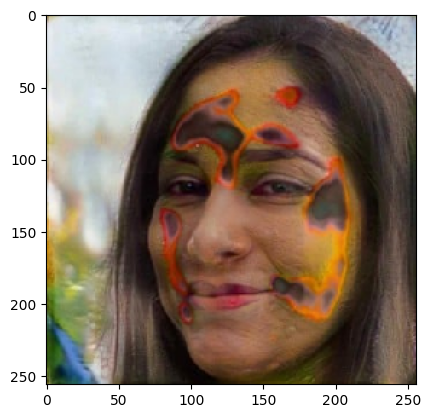

In [26]:
# Fake image(easy)
img_path = "manual_test_images/Easy.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))
prediction = cnn.predict(img_array)
print(prediction)

In [ ]:
# Saving model
from datetime import datetime
filename = f'models/cnn_{datetime.now().timestamp()}.h5'
tf.keras.models.save_model(cnn, filename)